# How do the weights learned by Oja's rule change when the input has errors?

But what effect do errors in the neural activity have?
* fixed activity
  * constant offset in waveform
  * constant offset in one neuron
  * additional white noise in neural activity



* dynamic activity and weights
  * Here we just have an error in the input because the weights and activity both start from zero...
  * Is it easier to get the weights and activity to converge if f=1 with the input than if f=2?

Do these depend on the harmonic that is used?

For fixed activity - no - see below




In [2]:
import numpy as np
import numpy.lib.stride_tricks
import matplotlib.pyplot as plt
import scipy.linalg
import matplotlib.scale
plt.style.use('seaborn-v0_8-notebook')
plt.rc('font',**{'family':'sans-serif','sans-serif':['Computer Modern Sans serif']})
plt.rc('text', usetex=True)
np.random.seed(7) # seed so plots are repeatable
%matplotlib inline
# need the %matplotlib inline for the following to work
plt.rc('figure', figsize = [10,6]) # paper figures should be width 10 (full linewidth) to have nicely readable text

def roll_matrix_rows(matrix, roll_amounts):
	'''roll each row of a 2D matrix by an independent amount, as specified in `roll_amounts`.'''
	matrix_rolled = matrix[:, [*range(matrix.shape[1]),*range(matrix.shape[1]-1)]].copy()
	stride_0, stride_1 = matrix_rolled.strides
	num_cols = matrix.shape[1]
	result = numpy.lib.stride_tricks.as_strided(matrix_rolled, (*matrix.shape, num_cols), (stride_0 ,stride_1, stride_1))
	return result[np.arange(matrix.shape[0]), (num_cols-roll_amounts) % num_cols]

In [3]:
profile_to_matrix = lambda profile: scipy.linalg.circulant(profile)
get_cosine_from_fourier_spectrum = lambda fourier_spectrum: np.fft.ifft(fourier_spectrum).real
circular_concat = lambda x : np.hstack((x, x[0]))

def fill_fourier_modes_up_to_N(last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements up to the `last_fourier_mode` filled with ones.
	
	`last_fourier_mode=0` corresponds to just the DC component being filled.
	
	For higher Fourier modes both the positive and negative frequency components are filled.
	
	eg. `fill_fourier_modes_up_to_N(1, 4) = [1,1,0,1]`
	'''
	assert last_fourier_mode <= period//2, f'last fourier mode of {last_fourier_mode} not possible with discrete Fourier vector of length {period}'
	half_fourier_vector = np.zeros(period//2+1)
	half_fourier_vector[:last_fourier_mode+1] = 1
	return np.hstack((half_fourier_vector, np.flip(half_fourier_vector[1:-1])))

def fill_fourier_modes_in_range(first_fourier_mode:int, last_fourier_mode:int, period: int):
	'''
	Create a vector of length `period` with the elements between `first_fourier_mode` and `last_fourier_mode` (inclusive) filled with ones, with other Fourier modes = 0.
	
	eg. `fill_fourier_modes_in_range(1, 2, 4) = [0,1,1,1]`
	'''
	fourier_spectrum = (fill_fourier_modes_up_to_N(last_fourier_mode, period) - fill_fourier_modes_up_to_N(first_fourier_mode-1, period))
	return fourier_spectrum


N = 8
neuron_indices = np.arange(N)
v_magnitude = 0.25
a = v_magnitude * np.cos(2*np.pi*neuron_indices/N) # a = ||v|| * F^-1{[1,0,0,...]}
_lambda = 1/4*N*v_magnitude**2
input = profile_to_matrix(a)

In [4]:
def simulate_and_plot_fixed_activity(a, W0=None, eta=0.01, plot=True, show=True):
	N = a.shape[1]
	if W0 is None:
		W = np.zeros((N,N))
	else:
		W = W0.copy()

	delta_W_trace = []
	W_trace = []

	for t in range(a.shape[0]):
		delta_W = a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - N/2*a[t,:].reshape(1,N)**2*W
		W += eta*delta_W
		delta_W_trace.append(delta_W.copy())
		W_trace.append(W.copy())

	if plot:
		plt.pcolor(W)
		plt.colorbar()
		if show:
			plt.show()
		plt.figure()
		plot_circulant_matrix_as_profile(W, show=show)

	return W, np.array(delta_W_trace), np.array(W_trace)

def get_circulant_matrix_profile(matrix):
	N = np.arange(matrix.shape[0])
	unrolled_matrix = roll_matrix_rows(matrix, -N)

	mu = unrolled_matrix.mean(axis=0)
	stddev = np.sqrt(unrolled_matrix.var(axis=0))

	return mu, stddev

def plot_circulant_matrix_as_profile(matrix, plot_stddev=True, roll=False, show=True):
	N = np.arange(matrix.shape[0]+1)
	mu, stddev = get_circulant_matrix_profile(matrix)
	if roll:
		N -= matrix.shape[0]//2
		mu = np.roll(mu, matrix.shape[0]//2)
		stddev = np.roll(stddev, matrix.shape[0]//2)

	plt.plot(N, circular_concat(mu), 'o--', markersize=6, linewidth=1)
	if plot_stddev:
		plt.fill_between(N, circular_concat(mu-stddev), circular_concat(mu+stddev), alpha=0.2)
	if show:
		plt.show()

## functions for generating phase portrait
def profile_to_mu_amp_phase(profile):
	return profile.mean(), (profile.max()-profile.min())/2, np.argmax(profile)

def grad_over_period(W, a, _lambda):
	grad_W = np.zeros_like(W)
	for t in range(a.shape[0]):
		grad_W += a[t,:].reshape(N,1) @ a[t,:].reshape(1,N) - _lambda*W
	return grad_W

def get_grad_over_period(mu, amp, eta=0.01, _lambda=5.0, f=1):
	input = profile_to_matrix(v_magnitude * np.cos(2*f*np.pi*neuron_indices/N))
	W = profile_to_matrix(mu + amp*np.cos(2*f*np.pi*neuron_indices/N))
	mu_before, amp_before, phase_before = profile_to_mu_amp_phase(get_circulant_matrix_profile(W)[0])
	mu_after, amp_after, phase_after = profile_to_mu_amp_phase(get_circulant_matrix_profile(W+eta*grad_over_period(W, input, _lambda))[0])
	return (mu_after-mu_before, amp_after-amp_before, phase_after-phase_before)

The weights converge to a sinusoidal profile which corresponds to the weights which make any sinusoidal activity stable

## Checking the standard deviation in the weights after learning

It ends up the same for $f=1$ and $f=3$ which isn't too surprising as they're just permutations of each other.

For $f=2$ there's weirdly no standard deviation...?

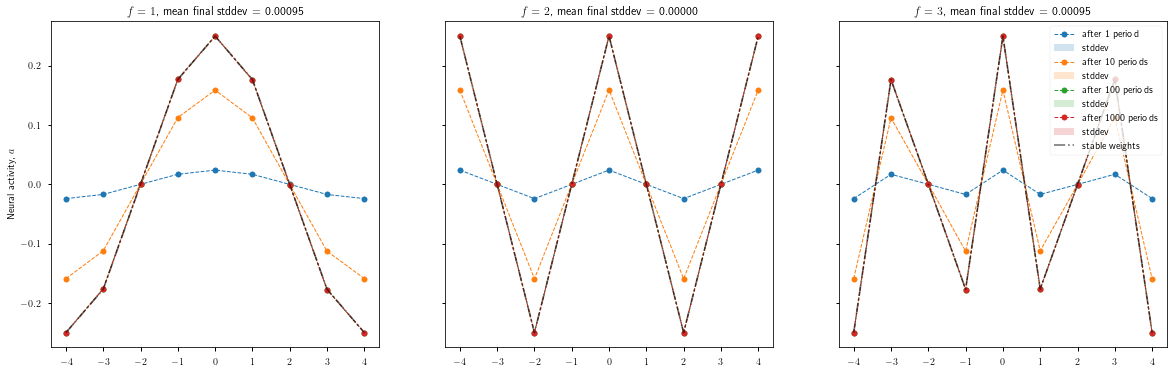

In [8]:
fig, axs=plt.subplots(1, 3, sharey=True, figsize=(20,6))

for f,ax in zip(range(1,4), axs):
	plt.sca(ax)
	input_spectrum = get_cosine_from_fourier_spectrum(fill_fourier_modes_in_range(f,f,N))
	input = profile_to_matrix(input_spectrum)

	W, delta_W_trace, W_trace = simulate_and_plot_fixed_activity(np.tile(input, (1000,1)), plot=False, eta=0.1)
	plot_circulant_matrix_as_profile(W_trace[N*1-1,:,:], plot_stddev=True, roll=True, show=False)
	plot_circulant_matrix_as_profile(W_trace[N*10-1,:,:], plot_stddev=True, roll=True, show=False)
	plot_circulant_matrix_as_profile(W_trace[N*100-1,:,:], plot_stddev=True, roll=True, show=False)
	plot_circulant_matrix_as_profile(W_trace[N*1000-1,:,:], plot_stddev=True, roll=True, show=False)
	plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(input_spectrum, N//2)), 'k-.', alpha=0.5)
	plt.title(f'$f = {f}$, mean final stddev = {get_circulant_matrix_profile(W_trace[N*1000-1,:,:])[1].mean():.5f}')
plt.legend(['after 1 period','stddev','after 10 periods','stddev','after 100 periods','stddev','after 1000 periods','stddev','stable weights'])
axs[0].set_ylabel('Neural activity, $a$')
plt.show()

## Adding some noise to the activity waveform and rotating this around the ring

Basically the exact same results for all the cases - as expected because going through the Fourier domain we end up at

$$\mathcal{F}_f[\omega] = \frac{\mathcal{F}_f[a]^2}{\|\mathcal{F}_f[a]\|^2}$$

So the Fourier spectrum of the weights is just the normalised Fourier spectrum of the rotating activity such that the $L_1$ norm of the weight Fourier spectrum is 1 (thanks to the $\lambda = \frac{N}{2}$ constant we added to Oja's rule to remove the effects of the discrete Fourier transform).

### Adding two input frequencies

The weights are just the normalised weighted sum of the 2 frequencies

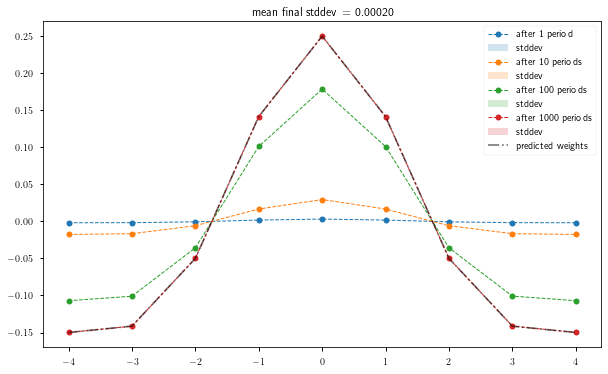

Fourier spectrum of a:	[0.  1.  0.5 0.  0. ]
F[a]^2 / ||F[a]||^2:	[0.  0.8 0.2 0.  0. ]
Fourier spectrum of W:	[0.  0.8 0.2 0.  0. ]
||a||^2 = 0.3125, ||F[a]||^2=1.2500
||W||_1: 1.0656, ||F[w]||_1=1.0000


In [22]:
fourier_spectrum_input = fill_fourier_modes_in_range(1,1,N) + 0.5*fill_fourier_modes_in_range(2,2,N)
input = profile_to_matrix(get_cosine_from_fourier_spectrum(fourier_spectrum_input))

eta = 0.01
periods = 1000
W, delta_W_trace, W_trace = simulate_and_plot_fixed_activity(np.tile(input, (periods,1)), plot=False, eta=eta)

plot_circulant_matrix_as_profile(W_trace[N*1-1,:,:], plot_stddev=True, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*10-1,:,:], plot_stddev=True, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*100-1,:,:], plot_stddev=True, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*1000-1,:,:], plot_stddev=True, roll=True, show=False)
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(2*fourier_spectrum_input**2/np.sum(fourier_spectrum_input**2)), N//2)), 'k-.', alpha=0.5)
plt.legend(['after 1 period','stddev','after 10 periods','stddev','after 100 periods','stddev','after 1000 periods','stddev','predicted weights'])
plt.title(f'mean final stddev = {get_circulant_matrix_profile(W_trace[N*1000-1,:,:])[1].mean():.5f}')
plt.show()

Fa = abs(np.fft.fft(input[0])).ravel()[:5]
Fw = abs(np.fft.fft(get_circulant_matrix_profile(W)[0]))[:5]
np.set_printoptions(precision=3, suppress=True)
print(f'Fourier spectrum of a:\t{Fa}')
print(f'F[a]^2 / ||F[a]||^2:\t{Fa**2 / (np.sum(Fa**2))}')
print(f'Fourier spectrum of W:\t{Fw}')
print(f'||a||^2 = {np.sum(input[0]**2):.4f}, ||F[a]||^2={np.sum(Fa**2):.4f}')
print(f'||W||_1: {np.sum(abs(get_circulant_matrix_profile(W)[0])):.4f}, ||F[w]||_1={np.sum(abs(Fw)):.4f}')
np.set_printoptions(edgeitems=3,infstr='inf',linewidth=75,nanstr='nan',precision=8,suppress=False,threshold=1000,formatter=None)

### Adding noise

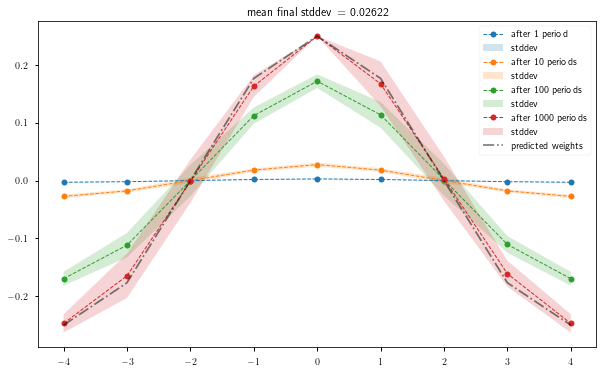

Fourier spectrum of a:	[0.125 1.347 0.035 0.216 0.01 ]
F[a]^2 / ||F[a]||^2:	[0.008 0.966 0.001 0.025 0.   ]
Fourier spectrum of W:	[0.01  0.961 0.001 0.033 0.   ]
||a||^2 = 0.4677, ||F[a]||^2=1.8786
||W||_1: 1.1582, ||F[w]||_1=1.0053


In [23]:
sigma=0.1
noise = sigma*np.random.randn(1,N)
fourier_spectrum_input = fill_fourier_modes_in_range(1,1,N)
input = profile_to_matrix(get_cosine_from_fourier_spectrum(fourier_spectrum_input)) + noise

eta = 0.01
periods = 1000
W, delta_W_trace, W_trace = simulate_and_plot_fixed_activity(np.tile(input, (periods,1)), plot=False, eta=eta)

plot_circulant_matrix_as_profile(W_trace[N*1-1,:,:], plot_stddev=True, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*10-1,:,:], plot_stddev=True, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*100-1,:,:], plot_stddev=True, roll=True, show=False)
plot_circulant_matrix_as_profile(W_trace[N*1000-1,:,:], plot_stddev=True, roll=True, show=False)
plt.plot(np.arange(-N//2, N//2+1), circular_concat(np.roll(get_cosine_from_fourier_spectrum(2*fourier_spectrum_input**2/np.sum(fourier_spectrum_input**2)), N//2)), 'k-.', alpha=0.5)
plt.legend(['after 1 period','stddev','after 10 periods','stddev','after 100 periods','stddev','after 1000 periods','stddev','predicted weights'])
plt.title(f'mean final stddev = {get_circulant_matrix_profile(W_trace[N*1000-1,:,:])[1].mean():.5f}')
plt.show()

Fa = abs(np.fft.fft(input[0])).ravel()[:5]
Fw = abs(np.fft.fft(get_circulant_matrix_profile(W)[0]))[:5]
np.set_printoptions(precision=3, suppress=True)
print(f'Fourier spectrum of a:\t{Fa}')
print(f'F[a]^2 / ||F[a]||^2:\t{Fa**2 / (np.sum(Fa**2))}')
print(f'Fourier spectrum of W:\t{Fw}')
print(f'||a||^2 = {np.sum(input[0]**2):.4f}, ||F[a]||^2={np.sum(Fa**2):.4f}')
print(f'||W||_1: {np.sum(abs(get_circulant_matrix_profile(W)[0])):.4f}, ||F[w]||_1={np.sum(abs(Fw)):.4f}')
np.set_printoptions(edgeitems=3,infstr='inf',linewidth=75,nanstr='nan',precision=8,suppress=False,threshold=1000,formatter=None)

## What if we just add noise to 1 neuron?

Our analysis kind of breaks because we don't have the same waveform smoothly rotating anymore